In [1]:

import gym
import random
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

from collections import deque
print("Gym:", gym.__version__)
print("Tensorflow:", tf.__version__)

C:\Users\user\.conda\envs\graph_rl\lib\site-packages\ale_py\roms\utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


Instructions for updating:
non-resource variables are not supported in the long term
Gym: 0.21.0
Tensorflow: 2.3.1


In [2]:
env_name = "CartPole-v0"
env = gym.make(env_name)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action space: Discrete(2)


In [3]:
class QNetwork():
    def __init__(self, state_dim, action_size, tau=0.01):
        tf.reset_default_graph()
        self.state_in = tf.placeholder(tf.float32, shape=[None, *state_dim])
        self.action_in = tf.placeholder(tf.int32, shape=[None])
        self.q_target_in = tf.placeholder(tf.float32, shape=[None])
        action_one_hot = tf.one_hot(self.action_in, depth=action_size)
        
        self.q_state_local = self.build_model(action_size, "local")
        self.q_state_target = self.build_model(action_size, "target")
        
        self.q_state_action = tf.reduce_sum(tf.multiply(self.q_state_local, action_one_hot), axis=1)
        self.loss = tf.reduce_mean(tf.square(self.q_state_action - self.q_target_in))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.loss)
        
        self.local_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="local")
        self.target_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="target")
        self.updater = tf.group([tf.assign(t, t + tau*(l-t)) for t,l in zip(self.target_vars, self.local_vars)])
        
    def build_model(self, action_size, scope):
        with tf.variable_scope(scope):
            hidden1 = tf.layers.dense(self.state_in, 100, activation=tf.nn.relu)
            q_state = tf.layers.dense(hidden1, action_size, activation=None)
            return q_state
        
    def update_model(self, session, state, action, q_target):
        feed = {self.state_in: state, self.action_in: action, self.q_target_in: q_target}
        session.run([self.optimizer, self.updater], feed_dict=feed)
        
    def get_q_state(self, session, state, use_target=False):
        q_state_op = self.q_state_target if use_target else self.q_state_local
        q_state = session.run(q_state_op, feed_dict={self.state_in: state})
        return q_state

In [4]:
class ReplayBuffer():
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        sample_size = min(len(self.buffer), batch_size)
        samples = random.choices(self.buffer, k=sample_size)
        return map(list, zip(*samples))

In [5]:
class DoubleDQNAgent():
    def __init__(self, env):
        self.state_dim = env.observation_space.shape
        self.action_size = env.action_space.n
        self.q_network = QNetwork(self.state_dim, self.action_size)
        self.replay_buffer = ReplayBuffer(maxlen=10000)
        self.gamma = 0.97
        self.eps = 1.0
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def get_action(self, state):
        q_state = self.q_network.get_q_state(self.sess, [state])
        action_greedy = np.argmax(q_state)
        action_random = np.random.randint(self.action_size)
        action = action_random if random.random() < self.eps else action_greedy
        return action
    
    def train(self, state, action, next_state, reward, done, use_DDQN=True):
        self.replay_buffer.add((state, action, next_state, reward, done))
        
        states, actions, next_states, rewards, dones = self.replay_buffer.sample(2)
        
        next_actions = np.argmax(self.q_network.get_q_state(self.sess, next_states, use_target=False), axis=1)

        q_next_states = self.q_network.get_q_state(self.sess, next_states, use_target=use_DDQN)
        
        q_next_states[dones] = np.zeros([self.action_size])

        q_next_states_next_actions = q_next_states[np.arange(next_actions.shape[0]), next_actions]

        q_targets = rewards + self.gamma * q_next_states_next_actions

        
        self.q_network.update_model(self.sess, states, actions, q_targets)
        
        if done: self.eps = max(0.1, 0.99*self.eps)
    
    def __del__(self):
        self.sess.close()

num_runs = 1
run_rewards = []

for n in range(num_runs):
    print("Run {}".format(n))
    ep_rewards = []
    agent = None
    agent = DoubleDQNAgent(env)
    num_episodes = 1

    for ep in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            agent.train(state, action, next_state, reward, done, use_DDQN=(n%2==0))
            total_reward += reward
            state = next_state

        ep_rewards.append(total_reward)
        print("Episode: {}, total_reward: {:.2f}".format(ep, total_reward))
        
    run_rewards.append(ep_rewards)

Run 0
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Episode: 0, total_reward: 17.00


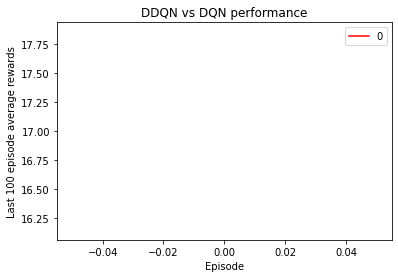

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

for n, ep_rewards in enumerate(run_rewards):
    x = range(len(ep_rewards))
    cumsum = np.cumsum(ep_rewards)
    avgs = [cumsum[ep]/(ep+1) if ep<100 else (cumsum[ep]-cumsum[ep-100])/100 for ep in x]
    col = "r" if (n%2==0) else "b"
    plt.plot(x, avgs, color=col, label=n)
    
plt.title("DDQN vs DQN performance")
plt.xlabel("Episode")
plt.ylabel("Last 100 episode average rewards")
plt.legend()

Q learning
1 ,  50.39999999999992 ,  0.0 ,  0.0
10 ,  74.26 ,  0.028315262241863197 ,  0.0
20 ,  80.36499999999995 ,  0.012397662497843109 ,  0.0
30 ,  79.42333333333336 ,  0.004802599364759607 ,  0.0
40 ,  74.67999999999999 ,  0.0014134076566537051 ,  0.0
50 ,  67.91800000000003 ,  0.00014261991572250103 ,  0.0
60 ,  61.01499999999991 ,  -0.0003759330157873631 ,  0.0
70 ,  54.70999999999996 ,  -0.0005556475215750152 ,  0.0
80 ,  49.30375000000001 ,  -0.0006238095730001602 ,  0.0
90 ,  44.73888888888883 ,  -0.000642832486306547 ,  0.0
100 ,  40.95200000000001 ,  -0.0006399981358176431 ,  0.0
110 ,  37.79454545454545 ,  -0.0006392330782258278 ,  0.0
120 ,  35.110000000000014 ,  -0.0006274967370182571 ,  0.0
130 ,  32.76384615384616 ,  -0.0006166767554670198 ,  0.0
140 ,  30.760000000000005 ,  -0.0006082345829373315 ,  0.0
150 ,  29.009333333333355 ,  -0.0005962508066246807 ,  0.0
160 ,  27.434999999999985 ,  -0.0005812601801288182 ,  0.0
170 ,  26.061764705882364 ,  -0.00056669786254317

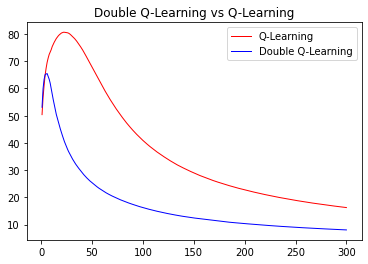

In [7]:

import numpy as np
import matplotlib.pyplot as plt


# these are the control variables, change them to customize the execution of this program
cntExperiments= 1001 # number of experiments to run, large number means longer execution time
MAX_ITER = 301      # number of episodes per experiment, large number means longer execution time
ACTIONS_FOR_B = 10  #number of actions at state B



#identify the states
STATE_A = 0
STATE_B = 1
STATE_C = 2
STATE_D = 3

#identify the actions
ACTION_LEFT = 0
ACTION_RIGHT = 1


#map actions to states
actionsPerState = {}
actionsPerState[STATE_A] = [ACTION_LEFT, ACTION_RIGHT]
actionsPerState[STATE_B] = [i for i in range(ACTIONS_FOR_B)]
actionsPerState[STATE_C] = [ACTION_RIGHT]
actionsPerState[STATE_D] = [ACTION_LEFT]

#init Q values
Q1={}
Q2={}


GAMMA = 1


# reset the variables, to be called on each experiment
def reset():
    Q1[STATE_A] = {}
    Q1[STATE_A][ACTION_LEFT] = 0
    Q1[STATE_A][ACTION_RIGHT] = 0

    Q1[STATE_B] = {}

    Q1[STATE_C] = {}
    Q1[STATE_C][ACTION_LEFT] = 0
    Q1[STATE_C][ACTION_RIGHT] = 0

    Q1[STATE_D] = {}
    Q1[STATE_D][ACTION_LEFT] = 0
    Q1[STATE_D][ACTION_RIGHT] = 0

    Q2[STATE_A] = {}
    Q2[STATE_A][ACTION_LEFT] = 0
    Q2[STATE_A][ACTION_RIGHT] = 0

    Q2[STATE_B] = {}

    Q2[STATE_C] = {}
    Q2[STATE_C][ACTION_LEFT] = 0
    Q2[STATE_C][ACTION_RIGHT] = 0

    Q2[STATE_D] = {}
    Q2[STATE_D][ACTION_LEFT] = 0
    Q2[STATE_D][ACTION_RIGHT] = 0
    for i in range(ACTIONS_FOR_B):
        Q1[STATE_B][i] = 0
        Q2[STATE_B][i] = 0


# epsilon greedy action
# it return action a 1-epsilon times
# and a random action epsilon times
def random_action(s, a, eps=.1):
    p = np.random.random()
    if p < (1 - eps):
        return a
    else:
        return np.random.choice(actionsPerState[s])


# move from state s using action a
# it returns the reward and the new state
def reward(s, a):
    if(s==STATE_A):
        if(a == ACTION_LEFT): return 0, STATE_B
        else: return 0, STATE_C
    if s==STATE_B:
        return np.random.normal(-.5, 1), STATE_D
    return 0, s

# returns the action that makes the max Q value, as welle as the max Q value
def maxQA(q, s):
    max=-9999
    sa = 0
    for k in q[s]:
        if(q[s][k] > max):
            max = q[s][k]
            sa = k
    return sa, max

# return true if this is a terminal state
def isTerminal(s):
    return s == STATE_C or s == STATE_D

# select the initial action at state A, it uses greedy method
# it takes into the mode doubleQLearning or not
def selectInitialAction(doubleQLearning, startState):
    if doubleQLearning:
        QS = {}
        QS[STATE_A] = {}
        QS[STATE_A][ACTION_LEFT] = Q1[STATE_A][ACTION_LEFT] + Q2[STATE_A][ACTION_LEFT]
        QS[STATE_A][ACTION_RIGHT] = Q1[STATE_A][ACTION_RIGHT] + Q2[STATE_A][ACTION_RIGHT]
        a, _ = maxQA(QS, startState)

    else:
        a, _ = maxQA(Q1, startState)
    return a

#update Q values depending on whether the mode  is doubleQLearning or not
def updateQValues(doubleQLearning, s, a, r, nxt_s, alpha):
    if doubleQLearning:
        p = np.random.random()
        if (p < .5):
            nxt_a, maxq = maxQA(Q1, nxt_s)
            Q1[s][a] = Q1[s][a] + alpha * (r + GAMMA * Q2[nxt_s][nxt_a] - Q1[s][a])
        else:
            nxt_a, maxq = maxQA(Q2, nxt_s)
            Q2[s][a] = Q2[s][a] + alpha * (r + GAMMA * Q1[nxt_s][nxt_a] - Q2[s][a])
    else:
        nxt_a, maxq = maxQA(Q1, nxt_s)
        Q1[s][a] = Q1[s][a] + alpha * (r + GAMMA * maxq - Q1[s][a])
    return nxt_a



# do the experiment by running MAX_ITER episodes and fill the restults in the episods parameter
def experiment(episods, doubleQLearning = False):
    reset()
    #contains the number of times left action is chosen at A
    ALeft = 0

    # contains the number of visits for each state
    N={}
    N[STATE_A] = 1
    N[STATE_B] = 1
    N[STATE_C] = 1
    N[STATE_D] = 1

    # contains the number of visits for each state and action
    NSA = {}

    # loop for MAX_ITER episods
    for i in range(1, MAX_ITER):

        s = STATE_A
        gameover = False

        # use greedy for the action at STATE A
        a = selectInitialAction(doubleQLearning, s)

        #loop until game is over, this will be ONE episode
        while not gameover:

            # apply epsilon greedy selection (including for action chosen at STATE A)
            a = random_action(s, a, 1/np.sqrt(N[s]))

            #update the number of visits for state s
            N[s] += 1

            # if left action is chosen at state A, increment the counter
            if (s == STATE_A and a == ACTION_LEFT):
                ALeft += 1

            #move to the next state and get the reward
            r, nxt_s = reward(s, a)

            #update the number of visists per state and action
            if not s in NSA:
                NSA[s] = {}
            if not a in NSA[s]:
                NSA[s][a] = 0
            NSA[s][a] += 1

            #compute alpha
            alpha = 1 / np.power(NSA[s][a], .8)

            #update the Q values and get the best action for the next state
            nxt_a = updateQValues(doubleQLearning, s, a, r, nxt_s, alpha)

            #if next state is terminal then mark as gameover (end of episode)
            gameover = isTerminal(nxt_s)

            s = nxt_s
            a = nxt_a

        #update stats for each episode
        if not (i in episods):
            episods[i] = {}
            episods[i]["count"] = 0
            episods[i]["Q1(A)"] = 0
            episods[i]["Q2(A)"] = 0
        episods[i]["count"] = ALeft
        episods[i]["percent"] = ALeft / i
        episods[i]["Q1(A)"] = ((episods[i]["Q1(A)"] * (i-1)) + Q1[STATE_A][ACTION_LEFT])/i
        episods[i]["Q2(A)"] = ((episods[i]["Q2(A)"] * (i-1)) + Q2[STATE_A][ACTION_LEFT])/i



# init a report structure
def initReport(report):
    for i in range(1,MAX_ITER):
        report[i] = {}
        report[i]["steps"] = i
        report[i]["count"] = 0
        report[i]["percent"] = 0
        report[i]["Q1(A)"] = 0
        report[i]["Q2(A)"] = 0


# run the learning
def runLearning(dblQLearn, report, experimentsCount):
    #run batch of experiments
    for k in range(1, experimentsCount):
        tmp = {}
        experiment(tmp, dblQLearn)
        #aggregate every experiment result into the final report
        for i in report:
            report[i]["count"] = ((report[i]["count"] * (k-1)) + tmp[i]["count"])/k
            report[i]["percent"] = 100*report[i]["count"] / i
            report[i]["Q1(A)"] = ((report[i]["Q1(A)"] * (k-1)) + tmp[i]["Q1(A)"])/k
            report[i]["Q2(A)"] = ((report[i]["Q2(A)"] * (k-1)) + tmp[i]["Q2(A)"])/k


# print the report
def printReport(dblQLearn, report):
    # display the final report
    print("Double Q Learning" if dblQLearn else "Q learning")
    for i in report:
        if(i==1 or i%10==0):
            print(i, ", ", report[i]["percent"],", ", report[i]["Q1(A)"],", ", report[i]["Q2(A)"])

# draw graphs of both curves QL and Double QL
def drawGraph(reportQl, reportDQl):
    steps=[]
    yQL=[]
    yDQL = []
    for i in reportQl:
        steps.append(i)
        yQL.append(reportQl[i]["percent"])
        yDQL.append(reportDQl[i]["percent"])

    df= {'steps':steps, 'yQL':yQL, 'yDQL':yDQL}
    # multiple line plot
    plt.plot('steps', 'yQL' , data=df, marker='', color='red', linewidth=1, label="Q-Learning")
    plt.plot('steps', 'yDQL', data=df, marker='', color='blue', linewidth=1, label="Double Q-Learning")
    plt.legend()
    plt.title("Double Q-Learning vs Q-Learning")
    plt.show()


# main ----------------------------------
# init report variables that will hold all the results
reportQL={}
reportDQL={}

initReport(reportQL)
initReport(reportDQL)

# run and print QLearning
runLearning(False, reportQL, cntExperiments)
printReport(False, reportQL)

# run and print Double QLearning
runLearning(True, reportDQL, cntExperiments)
printReport(True, reportDQL)

# print graphs
drawGraph(reportQL, reportDQL)